# Loading content

In [36]:
import os
import cobra
from modelseedpy import MSBuilder, MSATPCorrection, MSMedia, MSGapfill
import modelseedpy
import json
from tqdm import tqdm
import cobrakbase

modelseedpy 0.3.3
cobrakbase 0.4.0


## normalizing abundances

In [37]:
from math import pi

def fluxes_to_emissions(row):
    # TODO: LaTeX of the unit conversion
    # mmol/hr/g_bio -> umol/(m^2 * d)  via  / area (m^2) * (1000 umol / mmol) * (24 hours / day) * (g biomass / container)

    # defining the dimensions of the sampling system
    area_cm2 = pi * (5/2)**2 # cm^2
    area_m2 = area_cm2 * (1e-2)**2 # m^2
    volume_cm3 = 294.52 # cm^3

    # DNA per soil
    ugDNA_gSoil = 2 # approximate average from the provided spreadsheet
    DNA_per_biomass = 0.1
    gSoil_cm3 = 1.4   #  sourced from ChatGPT estimate
    gBiomass_gSoil = gSoil_cm3 * volume_cm3 * ugDNA_gSoil / DNA_per_biomass / 1000 / 1000  # estimated from Chris' spreadsheet
    
    return row / area_m2 * 1e3 * 24 * (gBiomass_gSoil)


from pandas import read_csv, DataFrame
def merge_depths_by_DNA(abundances):
    dna_df = read_csv("../data/SaltPondsDNA.csv").set_index("Sample")
    sample_dna = dna_df["DNA conc (µg/g soil)"].to_dict()
    unique_prefixes = {"_".join(i.split("_")[:-1]) for i in dna_df.index}
    # col_merged = {prefix: [prefix+"_D1", prefix+"_D2"] for prefix in unique_prefixes}
    # merged_depths = {}
    # for prefix in unique_prefixes:
    #     D1, D2 = prefix+"_D1", prefix+"_D2"
    #     total_dna = sample_dna[D1] + sample_dna[D2]
    #     merged_depths[prefix] = (sample_dna[D1]*abundances[D1] + sample_dna[D2]*abundances[D2]) / total_dna
    return DataFrame({prefix: (abundances[prefix+"_D1"]*sample_dna[prefix+"_D1"] + abundances[prefix+"_D2"]*sample_dna[prefix+"_D2"]) / (sample_dna[prefix+"_D1"] + sample_dna[prefix+"_D2"])
                      for prefix in unique_prefixes}, index=abundances.index)


In [38]:
# normalized_abundances = abundances.copy().T
# for col, column in normalized_abundances.iterrows():
#     # print(col)
#     # print(column)
#     normalized_abundances[col] = column/dna_df.loc[col]

from pandas import read_csv, DataFrame

dna_df = read_csv("../data/SaltPondsDNA.csv").set_index("Sample")
normalized_dna_df = read_csv("../data/SaltPondsDNA_methane_weighted.csv")
total_df = read_csv("../data/Cliff_Sample_Metadata_BGC_NMR.csv").set_index("Sample")
abundances = read_csv("../data/Cliff_310MAG_relabund.tsv", sep="\t")

normalized_methane = normalized_dna_df["CH4 (mmol/hr) / normalized_DNA"]
normalized_abundances = abundances.copy()
for col, val in dna_df["DNA conc (µg/g soil)"].items():
    normalized_abundances[col] = normalized_abundances[col] / val
    

unrestored_cols = [col for col in normalized_abundances.columns if ("R1_" in col or "R2_" in col) and "restored" not in col]
normalized_abundances.index.name = "MAG"
normalized_abundances.to_csv("normalized_MAG_abundances.csv")
display(normalized_abundances)


# averaged_normalized_abundances = DataFrame({prefix: normalized_abundances[cols].mean(axis=1) for prefix, cols in col_merged.items()}, index=normalized_abundances.index)
averaged_normalized_abundances = merge_depths_by_DNA(normalized_abundances)
unrestored_cols_simplified = [col for col in averaged_normalized_abundances.columns if ("R1_" in col or "R2_" in col) and "restored" not in col]
# averaged_normalized_abundances = normalized_abundances.groupby(prefixes, axis=1).mean()
averaged_normalized_abundances.to_csv("../data/averaged_normalized_MAG_abundances.csv")
display(averaged_normalized_abundances)

from pandas import read_csv, DataFrame, Series

averaged_normalized_abundances = read_csv("averaged_normalized_MAG_abundances.csv").set_index("Unnamed: 0")
averaged_unrestored_normalized_abundances = averaged_normalized_abundances[unrestored_cols_simplified]
averaged_unrestored_normalized_abundances.to_csv("averaged_normalized_abundances_unrestored.csv")

normalized_methane_df = total_df["CH4_umol_m2_d"] / dna_df["DNA conc (µg/g soil)"]
display(normalized_methane_df)
unique_prefixes = set(["_".join(col.split("_")[:-1]) for col in normalized_methane_df.index])
col_merged = {prefix: [prefix+"_D1", prefix+"_D2"] for prefix in unique_prefixes}
averaged_normalized_methane = Series({prefix: normalized_methane_df[cols].mean() for prefix, cols in col_merged.items()}, index=col_merged.keys())
averaged_unrestored_normalized_methane = averaged_normalized_methane[unrestored_cols_simplified]
methane_dic = averaged_unrestored_normalized_methane.to_dict()
json.dump(methane_dic, open("averaged_normalized_methane_unrestored.json", "w"), indent=3)
methane_dic

,SF2_A_D1,SF2_A_D2,SF2_B_D1,SF2_B_D2,SF2_C_D1,SF2_C_D2,R1_A_D1,R1_A_D2,R1_B_D1,R1_B_D2,R1_C_D1,R1_C_D2,R2A_A_D1,R2A_A_D2,R2A_B_D1,R2A_B_D2,R2A_C_D1,R2A_C_D2,R2_A_D1,R2_A_D2,R2_B_D1,R2_B_D2,R2_C_D1,R2_C_D2
MAG,,,,,,,,,,,,,,,,,,,,,,,,
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,6.615713e-03,6.034876e-03,3.731061e-03,6.514638e-03,7.592460e-03,5.035633e-03,1.644877e-07,2.926898e-07,6.317685e-07,3.836137e-07,1.243725e-06,1.321102e-06,3.138828e-04,1.916728e-04,7.961735e-05,7.731512e-04,3.317565e-05,5.741687e-05,3.459632e-07,1.009187e-06,2.137390e-05,6.398778e-07,1.452263e-06,1.424767e-05
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,3.521017e-04,8.955929e-04,7.186752e-04,1.256331e-03,2.581954e-03,2.143141e-03,1.930943e-07,1.573208e-07,1.340115e-07,4.583437e-07,2.540943e-07,1.924440e-06,3.469560e-05,7.446216e-06,2.618992e-06,3.734490e-05,3.687809e-06,2.285917e-06,8.649080e-07,1.282261e-06,5.114001e-06,5.576078e-07,8.220354e-08,1.020204e-05
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,4.462493e-04,5.474630e-03,1.458375e-03,3.433098e-03,1.201273e-02,1.339827e-02,2.252767e-07,2.012243e-07,5.130726e-07,2.192078e-07,6.285492e-07,7.073619e-07,4.383348e-06,6.235085e-06,4.467692e-06,4.152625e-04,2.859515e-05,5.422042e-04,1.049684e-06,1.757172e-06,2.609452e-05,6.947245e-07,9.919227e-07,1.090563e-05
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,4.388787e-03,8.007041e-03,1.392826e-02,2.549508e-02,2.132468e-02,2.335246e-02,2.109734e-07,3.219588e-07,4.862703e-07,3.836137e-07,1.163485e-06,1.289895e-06,4.878821e-05,3.027829e-05,3.981895e-05,2.119562e-03,3.402443e-05,2.049834e-04,1.191214e-06,2.517030e-06,2.425872e-05,1.000952e-06,1.227573e-06,1.459947e-05
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,6.926590e-05,2.986605e-03,4.803627e-05,1.140415e-04,1.487338e-04,3.686150e-03,4.398259e-06,3.395202e-06,5.701232e-06,7.373355e-06,2.032755e-05,1.048560e-05,1.051837e-05,1.026322e-04,5.118845e-05,1.487332e-03,6.989276e-05,5.128907e-04,3.742693e-06,3.716182e-06,1.896114e-04,1.611578e-05,1.103172e-05,1.058901e-04
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.40,1.181243e-04,6.548189e-03,4.549721e-04,2.287331e-03,8.706980e-04,1.317659e-02,8.188629e-07,7.609935e-07,1.121868e-06,1.340157e-06,2.219982e-06,3.079105e-06,1.376313e-07,9.778766e-06,3.081167e-07,2.824807e-05,8.727815e-05,2.130898e-04,1.930317e-06,1.685935e-06,2.077071e-04,1.145838e-05,9.426006e-07,9.586398e-05
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.55,2.167018e-03,2.753350e-03,1.987388e-03,3.248430e-03,3.168387e-03,2.212097e-03,3.010841e-06,3.183002e-06,4.119896e-06,5.086618e-06,1.397519e-05,7.905809e-06,6.754361e-05,2.053989e-04,6.576237e-05,3.654693e-04,3.750736e-05,4.927208e-05,3.042904e-06,4.119856e-06,1.294236e-04,5.589790e-06,9.897306e-06,1.039553e-04
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.8,7.174366e-03,7.578016e-03,5.033749e-03,8.789512e-03,1.074901e-02,7.107170e-03,4.612808e-07,5.634279e-07,1.336286e-06,7.423175e-07,2.059502e-06,2.683814e-06,2.636891e-04,2.587336e-04,1.074197e-04,5.853095e-04,4.742932e-05,2.084219e-05,1.702296e-06,2.849468e-06,5.192677e-05,1.275185e-06,3.342944e-06,3.236509e-05
Salt_Pond_MetaGSF2_A_H2O_MG_DASTool_bins_concoct_out.23,5.875459e-03,4.233689e-03,5.968762e-03,9.562044e-03,8.026225e-03,5.880015e-03,6.257686e-07,8.305074e-07,1.623454e-06,1.310265e-06,4.961526e-06,2.683814e-06,7.056732e-04,7.724777e-04,3.648410e-04,1.377452e-03,9.036596e-05,6.171977e-05,2.146544e-06,3.098797e-06,4.169877e-05,2.756045e-06,2.077009e-06,3.517944e-05


,R2A_B,SF2_B,R1_C,R2_B,SF2_C,R2_C,SF2_A,R2A_A,R2A_C,R2_A,R1_A,R1_B
MAG,,,,,,,,,,,,
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,1.547880e-04,4.648193e-03,1.286943e-06,1.758620e-06,6.482136e-03,2.025077e-06,6.325956e-03,3.038462e-04,4.260279e-05,5.329121e-07,2.281245e-07,5.217232e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,6.382861e-06,8.958220e-04,1.187038e-06,8.034564e-07,2.391396e-03,5.352400e-07,6.232283e-04,3.245773e-05,3.142629e-06,9.825511e-07,1.753371e-07,2.778380e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,4.899289e-05,2.109006e-03,6.725687e-07,2.065217e-06,1.261442e-02,1.435731e-06,2.954713e-03,4.535423e-06,2.283320e-04,1.249110e-06,2.133376e-07,3.827570e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,2.652380e-04,1.773929e-02,1.234089e-06,2.255867e-06,2.220526e-02,1.826195e-06,6.193793e-03,4.726807e-05,1.005085e-04,1.564934e-06,2.660642e-07,4.407468e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,2.068491e-04,6.978367e-05,1.483049e-05,2.547706e-05,1.684888e-03,1.527826e-05,1.524613e-03,1.808327e-05,2.421697e-04,3.735220e-06,3.900363e-06,6.442742e-06
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.40,3.336469e-06,1.058697e-03,2.699830e-06,2.204734e-05,6.214638e-03,5.191963e-06,3.325833e-03,9.294153e-07,1.362049e-04,1.861431e-06,7.901378e-07,1.218669e-06
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.55,9.824698e-05,2.402876e-03,1.058524e-05,1.227147e-05,2.753110e-03,1.410802e-05,2.459517e-03,7.886506e-05,4.208253e-05,3.346474e-06,3.096298e-06,4.548593e-06
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.8,1.592172e-04,6.271197e-03,2.408201e-06,4.008185e-06,9.167510e-03,4.642184e-06,7.375731e-03,2.632821e-04,3.708988e-05,2.025660e-06,5.119845e-07,1.072888e-06
Salt_Pond_MetaGSF2_A_H2O_MG_DASTool_bins_concoct_out.23,4.745958e-04,7.152676e-03,3.689349e-06,4.857272e-06,7.094215e-03,3.558912e-06,5.056444e-03,7.111596e-04,7.922577e-05,2.414965e-06,7.273966e-07,1.484569e-06


Sample
R1_A_D1       152.928650
R1_A_D2       155.159933
R1_B_D1       311.067580
R1_B_D2       390.397025
R1_C_D1       293.811901
R1_C_D2       232.230114
R2A_A_D1       -5.576805
R2A_A_D2      -62.329001
R2A_B_D1       -0.781991
R2A_B_D2       -6.432749
R2A_C_D1       -4.654720
R2A_C_D2       -7.314560
R2_A_D1       332.237984
R2_A_D2       846.415816
R2_B_D1     10044.312500
R2_B_D2       572.869534
R2_C_D1       466.860306
R2_C_D2      9961.768374
SF2_A_D1        3.775568
SF2_A_D2        3.792808
SF2_B_D1       33.499461
SF2_B_D2       68.174342
SF2_C_D1       18.229167
SF2_C_D2       23.748492
dtype: float64

{'R1_C': 263.0210073267493,
 'R2_B': 5308.591017144301,
 'R2_C': 5214.314339711316,
 'R2_A': 589.3269001387226,
 'R1_A': 154.04429155649183,
 'R2_B': 5308.591017144301,
 'R2_A': 589.3269001387226,
 'R1_C': 263.0210073267493,
 'R1_B': 350.7323023585634}

In [4]:
media = {'EX_cpd00067_e0': 1000.0,
 'EX_cpd00058_e0': 1000.0,
 'EX_cpd00013_e0': 1000.0,
 'EX_cpd00244_e0': 1000.0,
 'EX_cpd00205_e0': 1000.0,
 'EX_cpd00034_e0': 1000.0,
 'EX_cpd11574_e0': 1000.0,
 'EX_cpd00971_e0': 1000.0,
 'EX_cpd00048_e0': 1000.0,
 'EX_cpd00030_e0': 1000.0,
 'EX_cpd00305_e0': 100.0,
 'EX_cpd00001_e0': 1000.0,
 'EX_cpd10516_e0': 1000.0,
 'EX_cpd00007_e0': 1000.0,
 'EX_cpd00159_e0': 100.0,
 'EX_cpd25960_e0': 1000.0,
 "EX_cpd00009_e0": 100,
 'EX_cpd00063_e0': 1000.0,
 'EX_cpd00149_e0': 1000.0,
 'EX_cpd00254_e0': 1000.0,
 'EX_cpd00099_e0': 1000.0}

In [5]:
mepe = {  #mepn
    'Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.20.contigs',
 'Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.32.contigs',
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_concoct_out.51.contigs',
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.27.contigs',
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.28.contigs',
 'Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs',
 'Salt_Pond_MetaG_R1_C_D1_MG_DASTool_bins_metabat.31.contigs',
 'Salt_Pond_MetaG_R1_C_H2O_MG_DASTool_bins_concoct_out.79.contigs',
 'Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.35.contigs',
 'Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.49.contigs',
 'Salt_Pond_MetaG_R2_A_D2_MG_DASTool_bins_metabat.14.contigs',
 'Salt_Pond_MetaG_R2_A_D2_MG_DASTool_bins_metabat.16.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_concoct_out.143.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_concoct_out.32.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.10.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.16.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.19.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.38.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs',
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.88.contigs',
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.95.contigs',
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17.contigs',
 'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.18.contigs',
 'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs',
 'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.47.contigs',
 'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_concoct_out.17.contigs',
 'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs'}
mepe_striped = [x.replace(".contigs","") for x in mepe]


betaine = {'Salt_Pond_MetaG_R1_A_D1_MG_DASTool_bins.concoct_out.9.contigs',
 'Salt_Pond_MetaG_R1_A_D1_MG_DASTool_bins.metabat.47.contigs',
 'Salt_Pond_MetaG_R1_A_D1_MG_DASTool_bins.metabat.51.contigs',
 'Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_metabat.27.contigs',
 'Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_metabat.45.contigs',
 'Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_metabat.48.contigs',
 'Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_metabat.50.contigs',
 'Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_concoct_out.59.contigs',
 'Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.58.contigs',
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_concoct_out.73.contigs',
 'Salt_Pond_MetaG_R1_C_D1_MG_DASTool_bins_maxbin.047.contigs',
 'Salt_Pond_MetaG_R1_C_D2_MG_DASTool_bins_concoct_out.85.contigs',
 'Salt_Pond_MetaG_R1_C_D2_MG_DASTool_bins_metabat.40.contigs',
 'Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.98.contigs',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.52.contigs'}
betaine_striped = [x.replace(".contigs","") for x in betaine]

In [6]:
models = {}
for i in tqdm(mepe):
    # filename_model = f'./genome_scale/{i}.json'
    filename_model = f'../models/MePn_consumers/{i}.json'
    if os.path.exists(filename_model):
        models[i] = cobra.io.load_json_model(filename_model)
    else:
        print(f'skip {i}')

  0%|          | 0/27 [00:00<?, ?it/s]

 48%|████▊     | 13/27 [00:08<00:07,  1.77it/s]

skip Salt_Pond_MetaG_R2_A_D2_MG_DASTool_bins_metabat.14.contigs


 63%|██████▎   | 17/27 [00:09<00:05,  1.91it/s]

skip Salt_Pond_MetaG_R2_A_D2_MG_DASTool_bins_metabat.16.contigs


 74%|███████▍  | 20/27 [00:10<00:02,  2.47it/s]

skip Salt_Pond_MetaG_R1_C_D1_MG_DASTool_bins_metabat.31.contigs


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


In [ ]:
from modelseedpy.biochem import from_local
msdb = from_local("../../../shared/code/ModelSEEDDatabase")

for cpd in media:
    print(msdb.compounds.get_by_id(cpd.split("_")[1]).name)

H+
Cu2+
NH3
Ni2+
K+
Zn2+
Molybdate
Na+
Sulfate
Mn2+
Thiamin
H2O
Fe+3
O2
L-Lactate
MePn
Ca2+
Co2+
Mg
Cl-


# determine methane emission from methylphosphate as the sole phosphate source on lactate

In [ ]:
methane_emissions = {}
for ID, model in models.items():
    model.medium = media
    sol = model.optimize()
    if sol.objective_value == 0:
        print(f"{ID} failed") #, end="\n\n")
        continue
    methane_emissions[ID] = sol.fluxes['EX_cpd01024_e0']
    # print(f"{sol.fluxes['EX_cpd01024_e0']} methane flux from {ID}")

methane_emissions = dict(sorted(methane_emissions.items(), key=lambda item: item[1], reverse=True))
print()
display(methane_emissions)

Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.95.contigs failed
Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.88.contigs failed
Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.27.contigs failed
Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_concoct_out.17.contigs failed



{'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17.contigs': np.float64(0.3395442777379265),
 'Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.20.contigs': np.float64(0.33873119204370483),
 'Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.49.contigs': np.float64(0.3375697712315979),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_concoct_out.143.contigs': np.float64(0.33700864130145863),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.19.contigs': np.float64(0.335954875404964),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.38.contigs': np.float64(0.3353119564947358),
 'Salt_Pond_MetaG_R1_C_H2O_MG_DASTool_bins_concoct_out.79.contigs': np.float64(0.3316040687817319),
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.28.contigs': np.float64(0.3315597930392342),
 'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.47.contigs': np.float64(0.3291262866745024),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.10.contigs': np.float64(0.3282013837550686),
 'Salt_Pond_MetaG_R2_B_D2_MG_DA

## compare with the abundances of each respective species

In [ ]:
# import json
# abundances = json.load()
from pandas import read_csv

display(abundances)
sample_totals = abundances.sum(axis=0)
unrestored = abundances[abundances.index.to_series().str.contains(r'R1|R2')]
member_totals = unrestored.sum(axis=1).sort_values(ascending=False)
most_abundant_members = member_totals[:8]
display(sample_totals)
display(most_abundant_members)

,SF2_A_D1,SF2_A_D2,SF2_B_D1,SF2_B_D2,SF2_C_D1,SF2_C_D2,R1_A_D1,R1_A_D2,R1_B_D1,R1_B_D2,...,R2A_B_D1,R2A_B_D2,R2A_C_D1,R2A_C_D2,R2_A_D1,R2_A_D2,R2_B_D1,R2_B_D2,R2_C_D1,R2_C_D2
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,0.007762,0.007049,0.004617,0.003961,0.004373,0.002226,7.930502e-07,1.390862e-06,2.735979e-06,1.323723e-06,...,0.000179,0.000212,0.000051,0.000056,0.000001,0.000002,3.419824e-06,0.000002,4.941565e-06,0.000002
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,0.000413,0.001046,0.000889,0.000764,0.001487,0.000948,9.309720e-07,7.475883e-07,5.803591e-07,1.581591e-06,...,0.000006,0.000010,0.000006,0.000002,0.000003,0.000002,8.182401e-07,0.000002,2.797112e-07,0.000002
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,0.000524,0.006394,0.001804,0.002087,0.006919,0.005924,1.086134e-06,9.562176e-07,2.221946e-06,7.564132e-07,...,0.000010,0.000114,0.000044,0.000526,0.000004,0.000003,4.175123e-06,0.000002,3.375182e-06,0.000002
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,0.005150,0.009352,0.017234,0.015501,0.012283,0.010325,1.017173e-06,1.529948e-06,2.105874e-06,1.323723e-06,...,0.000090,0.000580,0.000052,0.000199,0.000005,0.000004,3.881395e-06,0.000003,4.177021e-06,0.000002
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,0.000081,0.003488,0.000059,0.000069,0.000086,0.001630,2.120547e-05,1.613400e-05,2.469013e-05,2.544299e-05,...,0.000115,0.000407,0.000107,0.000498,0.000015,0.000006,3.033782e-05,0.000045,3.753725e-05,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_concoct_out.44,0.000002,0.000003,0.000001,0.000001,0.000001,0.000001,6.723687e-07,1.234390e-06,1.674751e-06,1.925415e-06,...,0.000002,0.000003,0.000003,0.000002,0.000323,0.000045,1.649068e-05,0.000417,5.929878e-06,0.000813
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.002,0.000002,0.000004,0.000002,0.000002,0.000003,0.000002,1.861944e-06,3.181597e-06,8.920949e-06,1.028034e-05,...,0.000006,0.000005,0.000004,0.000004,0.001588,0.000173,7.385141e-05,0.001671,1.695050e-05,0.002780
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.005,0.000006,0.000003,0.000004,0.000003,0.000003,0.000002,2.346394e-05,3.320683e-05,8.771713e-05,7.485053e-05,...,0.000002,0.000003,0.000003,0.000002,0.000254,0.000113,8.144636e-05,0.000112,1.427273e-04,0.000129
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.017,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,3.748024e-05,4.779350e-05,3.856901e-05,5.152205e-05,...,0.000003,0.000002,0.000002,0.000001,0.000145,0.000045,5.744465e-05,0.000159,5.320108e-05,0.000174


SF2_A_D1    1.0
SF2_A_D2    1.0
SF2_B_D1    1.0
SF2_B_D2    1.0
SF2_C_D1    1.0
SF2_C_D2    1.0
R1_A_D1     1.0
R1_A_D2     1.0
R1_B_D1     1.0
R1_B_D2     1.0
R1_C_D1     1.0
R1_C_D2     1.0
R2A_A_D1    1.0
R2A_A_D2    1.0
R2A_B_D1    1.0
R2A_B_D2    1.0
R2A_C_D1    1.0
R2A_C_D2    1.0
R2_A_D1     1.0
R2_A_D2     1.0
R2_B_D1     1.0
R2_B_D2     1.0
R2_C_D1     1.0
R2_C_D2     1.0
dtype: float64

Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_metabat.12    0.320442
Salt_Pond_MetaG_R2_B_D1_MG_DASTool_bins_metabat.13    0.225916
Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.28    0.199881
Salt_Pond_MetaG_R2_B_D1_MG_DASTool_bins_metabat.10    0.184577
Salt_Pond_MetaG_R1_C_D1_MG_DASTool_bins_metabat.19    0.167538
Salt_Pond_MetaG_R1_A_H2O_MG_DASTool_bins_metabat.8    0.139007
Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.29    0.119100
Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17    0.115763
dtype: float64

# notes
- the Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17 organism both generates the most methane emission of all organisms and is the only one of the most abundant members that was defined with a model in the MePn set of organisms
- 

In [ ]:
from pandas import read_csv

# compute the dimensions of the sampling core
def convert_methane(methane):
    # TODO: LaTeX of the unit conversion
    # umol/(m^2 * d) -> mmol/hr  via  * area (m^2) * (1 mmol/1000 umol) * (1 day / 24 hours)

    # defining the dimensions of the sampling system
    from math import pi
    # sample_volume = 294.52 # cm^3
    sample_area = pi * (5/2)**2 # cm^2
    
    ## standard units
    # sample_volume = sample_volume * (1e-2)**3 # m^3
    sample_area = sample_area * (1e-2)**2 # m^2

    # returning the mmol/hr methane fluxes
    gBiomass_gSoil = 5.9 * 1000
    
    return methane * sample_area / (1e3 * 24)

# print(sample_volume, sample_area)

# load and connect the DNA with the methane flux
methane = convert_methane(total_df["CH4_umol_m2_d"])
for sample in dna_df.index:
    dna_df.loc[sample, "methane"] = methane[sample]  # mmol/hr

# normalize the DNA/g by the methane flux
for sample in dna_df.index:
    dna_df.loc[sample, "CH4 (mmol/hr) / normalized_DNA"] = dna_df.loc[sample, "methane"] / dna_df.loc[sample, "DNA conc (µg/g soil)"]

# normalize to 1
# total_normalized_dna = dna_df.loc[:, "DNA/g/methane"].sum()
# dna_df["normalized DNA/g/methane"] = dna_df["DNA/g/methane"] / total_normalized_dna

display(dna_df)

dna_df.to_csv("../data/SaltPondsDNA_methane_weighted.csv")
# display(methane)

,DNA conc (µg/mL) in 20 µL extracted from 0.25 g soil,DNA (ug),DNA conc (µg/g soil),methane,CH4 (mmol/hr) / normalized_DNA
Sample,,,,,
R1_A_D1,60.266667,1.205333,4.821333,6.032185e-05,1.251145e-05
R1_A_D2,59.400000,1.188000,4.752000,6.032185e-05,1.269399e-05
R1_B_D1,54.133333,1.082667,4.330667,1.102118e-04,2.544916e-05
R1_B_D2,43.133333,0.862667,3.450667,1.102118e-04,3.193928e-05
R1_C_D1,20.866667,0.417333,1.669333,4.012648e-05,2.403743e-05
R1_C_D2,26.400000,0.528000,2.112000,4.012648e-05,1.899928e-05
R2_A_D1,49.933333,0.998667,3.994667,1.085797e-04,2.718116e-05
R2_A_D2,19.600000,0.392000,1.568000,1.085797e-04,6.924723e-05
R2_B_D1,2.000000,0.040000,0.160000,1.314797e-04,8.217484e-04


# correlate the normalized abundances of members with the normalized methane flux

In [ ]:
correlations = {}
for index, row in normalized_abundances.iterrows():
    corr = row.corr(normalized_methane)
    correlations[index] = corr
    # print(f"{index} correlates {corr} with methane")

correlations = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True))
# print("total correlation", sum(correlations.values()))
merged_corr = 0
for org, val in correlations.items():
    if org in mepe_striped:  merged_corr += val
# print("summed mepe correlations", merged_corr)
print("max all correlations", max(correlations.values()))
unrestored_correlations = {k:v for k,v in correlations.items() if ("R1_" in k or "R2_" in k) and not "restored" in k}
print(unrestored_correlations['Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17'])
unrestored_correlations

max all correlations 0.9933389305491771
0.9736930734718282


{'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45': np.float64(0.9933389305491771),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.16': np.float64(0.993120804564738),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55': np.float64(0.9910633253089762),
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.98': np.float64(0.9897259768241059),
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.95': np.float64(0.9893764565409581),
 'Salt_Pond_MetaG_R2_B_D1_MG_DASTool_bins_metabat.13': np.float64(0.9876012116481486),
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.16': np.float64(0.9872359225769332),
 'Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.5': np.float64(0.9854061134057847),
 'Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7': np.float64(0.9853776265009595),
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.30': np.float64(0.9837327339337952),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.52': np.float64(0.9830769058301974),
 'Salt_Pond_MetaG_R1_B_D1_MG_DAS

In [ ]:
import numpy as np
print(np.mean(list(unrestored_correlations.values())), np.mean(list(unrestored_correlations.values()))**2, np.std(list(unrestored_correlations.values())))

0.8139577554324168 0.662527227628578 0.21198574084908497


## look at the total abundances of MePn consumers and betaine reducers

In [ ]:
merged_normalized_abundances = normalized_abundances.copy()
merged_normalized_abundances.loc["mepe"] = normalized_abundances.loc[mepe_striped].sum()
merged_normalized_abundances.loc["betaine_reducers"] = normalized_abundances.loc[betaine_striped].sum()
merged_normalized_abundances = merged_normalized_abundances.drop(mepe_striped)
merged_normalized_abundances

,SF2_A_D1,SF2_A_D2,SF2_B_D1,SF2_B_D2,SF2_C_D1,SF2_C_D2,R1_A_D1,R1_A_D2,R1_B_D1,R1_B_D2,...,R2A_B_D1,R2A_B_D2,R2A_C_D1,R2A_C_D2,R2_A_D1,R2_A_D2,R2_B_D1,R2_B_D2,R2_C_D1,R2_C_D2
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,0.006616,0.006035,0.003731,0.006515,0.007592,0.005036,1.644877e-07,2.926898e-07,6.317685e-07,3.836137e-07,...,7.961735e-05,0.000773,0.000033,0.000057,3.459632e-07,0.000001,0.000021,6.398778e-07,1.452263e-06,0.000014
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,0.000352,0.000896,0.000719,0.001256,0.002582,0.002143,1.930943e-07,1.573208e-07,1.340115e-07,4.583437e-07,...,2.618992e-06,0.000037,0.000004,0.000002,8.649080e-07,0.000001,0.000005,5.576078e-07,8.220354e-08,0.000010
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,0.000446,0.005475,0.001458,0.003433,0.012013,0.013398,2.252767e-07,2.012243e-07,5.130726e-07,2.192078e-07,...,4.467692e-06,0.000415,0.000029,0.000542,1.049684e-06,0.000002,0.000026,6.947245e-07,9.919227e-07,0.000011
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,0.004389,0.008007,0.013928,0.025495,0.021325,0.023352,2.109734e-07,3.219588e-07,4.862703e-07,3.836137e-07,...,3.981895e-05,0.002120,0.000034,0.000205,1.191214e-06,0.000003,0.000024,1.000952e-06,1.227573e-06,0.000015
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,0.000069,0.002987,0.000048,0.000114,0.000149,0.003686,4.398259e-06,3.395202e-06,5.701232e-06,7.373355e-06,...,5.118845e-05,0.001487,0.000070,0.000513,3.742693e-06,0.000004,0.000190,1.611578e-05,1.103172e-05,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.005,0.000005,0.000003,0.000003,0.000005,0.000006,0.000004,4.866691e-06,6.987969e-06,2.025488e-05,2.169161e-05,...,7.600211e-07,0.000011,0.000002,0.000002,6.362185e-05,0.000072,0.000509,3.977298e-05,4.194573e-05,0.000810
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.017,0.000002,0.000002,0.000002,0.000003,0.000004,0.000004,7.773833e-06,1.005755e-05,8.906021e-06,1.493104e-05,...,1.119491e-06,0.000008,0.000002,0.000002,3.631827e-05,0.000029,0.000359,5.656977e-05,1.563511e-05,0.001089
unbinned_reads,0.804522,0.759152,0.732928,1.463329,1.602282,1.708192,9.309582e-02,9.058212e-02,1.156331e-01,1.228118e-01,...,4.155628e-01,3.359769,0.557968,0.821472,1.608085e-01,0.343942,3.859278,1.933192e-01,1.658099e-01,3.595310
mepe,0.000595,0.000745,0.001242,0.003200,0.001659,0.003441,1.387740e-02,1.490227e-02,2.393991e-02,2.761568e-02,...,1.615404e-03,0.004680,0.001490,0.001183,1.827708e-02,0.024067,0.434797,4.643770e-02,2.330005e-02,0.564502


# MePn reducers

# TODO correlate with all the experimental metabolites, including MePn

In [ ]:
merged_correlations = {}
for index, row in merged_normalized_abundances.iterrows():
    corr = row.corr(normalized_methane)
    merged_correlations[index] = corr
    # print(f"{index} correlates {corr} with methane")

merged_correlations = dict(sorted(merged_correlations.items(), key=lambda item: item[1], reverse=True))
merged_correlations
# print("max all correlations", max(merged_correlations.values()))
# unrestored_merged_correlations = {k:v for k,v in merged_correlations.items() if ("R1_" in k or "R2_" in k) and not "restored" in k}
# unrestored_merged_correlations

{'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.13': np.float64(0.9922588688990923),
 'Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.98': np.float64(0.9897259768241059),
 'Salt_Pond_MetaG_R2_B_D1_MG_DASTool_bins_metabat.13': np.float64(0.9876012116481486),
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.16': np.float64(0.9872359225769332),
 'mepe': np.float64(0.986741540640257),
 'Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.5': np.float64(0.9854061134057847),
 'Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.30': np.float64(0.9837327339337952),
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.52': np.float64(0.9830769058301974),
 'Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.11': np.float64(0.9822720369608353),
 'Salt_Pond_MetaG_R1_C_D2_MG_DASTool_bins_metabat.30': np.float64(0.9822702702526581),
 'Salt_Pond_MetaG_R2_B_D1_MG_DASTool_bins_concoct_out.40': np.float64(0.9819724781554824),
 'Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_metabat.36': np.float64(0.9

# Simulation

In [10]:
dontGrow = []
for ID, model in models.items():
    ogMedia = model.medium
    model.medium = media
    sol = model.optimize()
    if sol.status == "infeasible":
        print(ID, "is infeasible")
    elif sol.objective_value == 0:
        print(ID, "doesn't grow")
        dontGrow.append(ID)
    else: print(sol)
    model.medium = ogMedia

<Solution 5.118 at 0x16b5ac250>
<Solution 4.006 at 0x30ac52690>
<Solution 5.084 at 0x30ac532d0>
<Solution 4.976 at 0x30ac500d0>
Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_concoct_out.17.contigs doesn't grow
<Solution 4.866 at 0x30ac516d0>
<Solution 5.084 at 0x30ac50990>
<Solution 0.002 at 0x30ac52690>
<Solution 5.150 at 0x30ac50350>
<Solution 0.002 at 0x30ac50390>
<Solution 0.002 at 0x30ac50190>
<Solution 5.106 at 0x30ac50e50>
<Solution 5.114 at 0x30ac50910>
<Solution 5.023 at 0x30ac50050>
<Solution 4.695 at 0x30ac50d90>
<Solution 4.990 at 0x30ac53290>
<Solution 5.111 at 0x30ac512d0>
Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.88.contigs doesn't grow
Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_concoct_out.95.contigs doesn't grow
<Solution 5.136 at 0x30ac50150>
<Solution 5.024 at 0x30ac50310>
Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.27.contigs doesn't grow
<Solution 5.093 at 0x30ac50050>
<Solution 5.148 at 0x30ac511d0>


In [ ]:
config = cobra.Configuration()
config

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,335
cache_directory,Path for the model cache,/home/afreiburger/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## simulate the MePn-consuming organisms

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from optlang.symbolics import Zero
import numpy as np

sols = {}
# methane_production, lactate_consumption, = {}, {}
# media["EX_cpd00009_e0"] = 10
fits, fluxes = {}, {}

with open("sols_log.txt", 'w') as f:
    for multiple in [0.07, .33]: # + list(np.logspace(-1, 1, 10)):
        fluxes[multiple] = {"methane": {}, "lactate": {}, "phosphate": {}, "MePn": {}}
        for orgID, row in averaged_unrestored_normalized_abundances.iterrows():
            # print(orgID)
            ID = orgID+".contigs"
            if ID not in models or ID in dontGrow:  continue
            model = models[ID].copy()

            # phosphate ratio constraint
            constraint = model.problem.Constraint(Zero, lb=0, ub=None, name="Phosphate_ratio")
            model.add_cons_vars(constraint)
            model.solver.update()
            # MePn >= multiple * Pi
            constraint.set_linear_coefficients(coefficients = {
                model.reactions.EX_cpd00009_e0.forward_variable: multiple,
                model.reactions.EX_cpd00009_e0.reverse_variable: -multiple,
                model.reactions.EX_cpd25960_e0.forward_variable: -1,
                model.reactions.EX_cpd25960_e0.reverse_variable: 1})
                # model.reactions.EX_cpd00009_e0.forward_variable: multiple,
                # model.reactions.EX_cpd25960_e0.forward_variable: -1})
            # display(constraint.ub, constraint.expression, constraint.lb)
            model.solver.update()
            
            model.medium = media
            bio = model.reactions.get_by_id("bio1")
            model.solver.configuration.timeout = 15
            sols[ID] = {}
            for k, dic in fluxes[multiple].items():
                fluxes[multiple][k][ID] = {}
            f.write(f"\n\n{orgID}")
            for sample, abundance in row.items():
                # fix the biomass
                bio.bounds = (abundance, abundance)
                # define lactate as a the objective
                EX = model.reactions.get_by_id("EX_cpd00159_e0")
                EX.bounds = (-1000, 0)
                model.objective = EX
                f.write(f"\noptimizing {sample} at {abundance}")
                sols[ID][sample] = model.optimize()
                if sols[ID][sample].status == "infeasible":
                    f.write(f"Feasibility Error: {ID} {sample}")
                
                fluxes[multiple]["methane"][ID][sample] = sols[ID][sample].fluxes.EX_cpd01024_e0
                fluxes[multiple]["lactate"][ID][sample] = sols[ID][sample].fluxes.EX_cpd00159_e0
                fluxes[multiple]["phosphate"][ID][sample] = sols[ID][sample].fluxes.EX_cpd00009_e0
                # fluxes[multiple]["phosphate"][ID][sample] = model.reactions.EX_cpd00009_e0.reverse_variable.primal
                fluxes[multiple]["MePn"][ID][sample] = sols[ID][sample].fluxes.EX_cpd25960_e0
                # fluxes[multiple]["MePn"][ID][sample] = model.reactions.EX_cpd25960_e0.reverse_variable.primal
                
                bio.bounds = (0, 0)
                bio_flux = sols[ID][sample].fluxes.bio1
                if bio_flux != abundance:
                    f.write(f"\nAbundance Error: {bio_flux} != {abundance}")
                f.write(f"\noptimized at {sols[ID][sample].fluxes.EX_cpd00159_e0}")
    
        # determine the linear regression of fitting the experimental data with the simulation fluxes
        mdl = LinearRegression()
        xs = np.array(list(methane_dic.values())).reshape(-1, 1)
        methane_df = DataFrame(fluxes[multiple]["methane"])
        ys = np.array(fluxes_to_emissions(methane_df.T.sum()).to_list())
        mdl.fit(xs, ys)
        y_pred = mdl.predict(xs)
        fits[multiple] = {"eq": f"y = {mdl.coef_[0]:.2f}x + {mdl.intercept_:.2f}",
                          "R2": f"$R^2$ = {r2_score(ys, y_pred):.8f}"}

        mepn_df = DataFrame(fluxes[multiple]["MePn"])
        phosphate_df = DataFrame(fluxes[multiple]["phosphate"])
        # display(mepn_df)
        print("\nMinimum MePn/Phosphate ratio", multiple)
        print("total MePn consumed:", mepn_df.sum(axis=1).to_dict())
        print("total inorganic Phosphate consumed:", phosphate_df.sum(axis=1).to_dict())
        print(fits[multiple])
        # print(sum(list(.values()))
        # break
        # print(fluxes[multiple]["phosphate"]['Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs'])
        # print(fluxes[multiple]["MePn"]['Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs'])

json.dump(fits, open("fits.json", 'w'), indent=3)
json.dump(fluxes, open("saltern_fluxes.json", 'w'), indent=3)

/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f


Minimum MePn/Phosphate ratio 0.07
total MePn consumed: {'R2_C': -0.028365322674484703, 'R1_A': -0.0017717546724596899, 'R2_B': -0.027858955793534822, 'R2_A': -0.001641265739627526, 'R1_C': -0.005920965529428517, 'R1_B': -0.0028507609560914395}
total inorganic Phosphate consumed: {'R2_C': -0.14867171963939776, 'R1_A': -0.007103016454197414, 'R2_B': -0.10928480236801683, 'R2_A': -0.007311309058859013, 'R1_C': -0.022707394458154877, 'R1_B': -0.012291319596803485}
{'eq': 'y = 0.51x + 138.48', 'R2': '$R^2$ = 0.97828062'}


/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f


Minimum MePn/Phosphate ratio 0.33
total MePn consumed: {'R2_C': -0.056440860480034764, 'R1_A': -0.003085649417768163, 'R2_B': -0.048044952158359015, 'R2_A': -0.003010561802076154, 'R1_C': -0.010098177352233666, 'R1_B': -0.005143213806276558}
total inorganic Phosphate consumed: {'R2_C': -0.12059618183613853, 'R1_A': -0.005789121709098119, 'R2_B': -0.08909880600318905, 'R2_A': -0.005942012996409809, 'R1_C': -0.018530182635350365, 'R1_B': -0.009998866746618838}
{'eq': 'y = 0.95x + 223.77', 'R2': '$R^2$ = 0.96812476'}


/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
# display(model.reactions.EX_cpd00009_e0.reaction)
# viewing the phosphate constraints
for cons in model.constraints:
    if "Phosphate" in cons.name:
        print(cons.name)
        print(cons.ub, ">=", cons.expression, ">=", cons.lb)

Phosphate_ratio
0 >= 10.0*EX_cpd00009_e0_reverse_97c79 - 1.0*EX_cpd25960_e0_reverse_e4a29 >= None


### compute the methane emission from substrate addition of MePn

In [8]:
additional_methane_generated = 10 # umol
hours_equilibrated = 14 * 24 # hours
volume_added = 10 # mL
concentration_added = 100 # umol/L
substrate_added = concentration_added * (volume_added/1000)  # umol
substrate_flux = substrate_added #  / hours_equilibrated  # not divided by time because all of the substrate was added at once
additional_methane_flux = additional_methane_generated / hours_equilibrated  # umol/hr
print(additional_methane_flux, "umol/hr methane flux from addition")

0.02976190476190476 umol/hr methane flux from addition


In [36]:
substrate_added

1.0

In [73]:
averaged_unrestored_normalized_abundances

,R1_A,R2_B,R1_C,R2_C,R2_A,R1_B
Unnamed: 0,,,,,,
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,2.285888e-07,0.000011,1.282414e-06,0.000008,6.775749e-07,5.076911e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,1.752075e-07,0.000003,1.089267e-06,0.000005,1.073584e-06,2.961776e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,2.132505e-07,0.000013,6.679555e-07,0.000006,1.403428e-06,3.661402e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,2.664661e-07,0.000013,1.226690e-06,0.000008,1.854122e-06,4.349420e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,3.896730e-06,0.000103,1.540657e-05,0.000058,3.729437e-06,6.537293e-06
...,...,...,...,...,...,...
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_concoct_out.44,1.996096e-07,0.000126,3.355478e-06,0.002550,5.490922e-05,4.723512e-07
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.002,5.278583e-07,0.000529,1.325396e-05,0.008717,2.540135e-04,2.519591e-06
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.005,5.927330e-06,0.000274,2.215507e-05,0.000426,6.790419e-05,2.097325e-05


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from optlang.symbolics import Zero
import numpy as np

# methane_production, lactate_consumption, = {}, {}
# media["EX_cpd00009_e0"] = 10
 # mmol and divided by 3 to account for the lack of a community model to share it among all members
 ## yet there are generally 1-3 MePn consumers per sample so dividing by 3 is a reasonable approximation
media["EX_cpd25960_e0"] = substrate_flux / 1000 # / 3   # mmol
display(media)
print("members", len(averaged_unrestored_normalized_abundances.index))
fits_addition, fluxes_addition = {}, {}
MePn_consumers = {}

fluxes_addition = {"methane": {}, "lactate": {}, "phosphate": {}, "MePn": {}}
total_methane_emissions = np.array([0.0]*len(averaged_unrestored_normalized_abundances.columns))
total_MePn_consumption = np.array([0.0]*len(averaged_unrestored_normalized_abundances.columns))
for orgID, row in averaged_unrestored_normalized_abundances.iterrows():
    # print(orgID)
    ID = orgID+".contigs"
    if ID not in models or ID in dontGrow:  continue
    model = models[ID].copy()


    model.medium = media
    bio = model.reactions.get_by_id("bio1")
    model.solver.configuration.timeout = 15
    for k, dic in fluxes_addition.items():
        fluxes_addition[k][ID] = {}
    for sample, abundance in row.items():
        # constrain biomass and lactate consumption
        bio.bounds = (abundance, abundance)
        EX = model.reactions.get_by_id("EX_cpd00159_e0")
        # EX.bounds = (-1000, 0)
        model.objective = EX
        # model.objective_direction = "max"
        # print(model.reactions.get_by_id("EX_cpd25960_e0").bounds)
        # model.reactions.get_by_id("EX_cpd25960_e0").lower_bound = -media["EX_cpd25960_e0"]
        sol = model.optimize()
        if sol.status == "infeasible":
            print(f"Feasibility Error: {ID} in {sample}")
            continue

        if abs(sol.fluxes.EX_cpd25960_e0) > 1e-9:
            MePn_consumers[sample] = MePn_consumers.get(sample, set())
            MePn_consumers[sample].add(ID)
        if abs(model.reactions.get_by_id("EX_cpd25960_e0").lower_bound) < abs(sol.fluxes.EX_cpd25960_e0):
            display(model.medium)
            raise ValueError(f"MePn flux {sol.fluxes.EX_cpd25960_e0} is greater than the lower bound \
                {model.reactions.get_by_id('EX_cpd25960_e0').lower_bound} for {ID} {sample}")

        fluxes_addition["methane"][ID][sample] = sol.fluxes.EX_cpd01024_e0
        fluxes_addition["lactate"][ID][sample] = sol.fluxes.EX_cpd00159_e0
        fluxes_addition["phosphate"][ID][sample] = sol.fluxes.EX_cpd00009_e0
        fluxes_addition["MePn"][ID][sample] = sol.fluxes.EX_cpd25960_e0
        
        bio.bounds = (0, 0)
        bio_flux = sol.fluxes.bio1
        if bio_flux != abundance:
            print(f"Abundance Error: {bio_flux} != {abundance}")

    # print("methylphosphonate consumption")
    # display(DataFrame(fluxes_addition["MePn"]))

    xs = np.array(list(methane_dic.values())).reshape(-1, 1)
    methane_df = DataFrame(fluxes_addition["methane"])
    methane_producing_members = methane_df.sum()[methane_df.sum() > 0].index
    if len(methane_producing_members) == 0:
        print(f"Skipping {ID} because no methane was produced")
        continue
    ys = np.array(methane_df.T.sum().to_list())
    mdl = LinearRegression()
    mdl.fit(xs, ys)
    y_pred = mdl.predict(xs)
    fits_addition = {"eq": f"y = {mdl.coef_[0]:.2f}x + {mdl.intercept_:.2f}",
                        "R2": f"$R^2$ = {r2_score(ys, y_pred):.8f}"}

    mepn_addition_df = DataFrame(fluxes_addition["MePn"])
    phosphate_addition_df = DataFrame(fluxes_addition["phosphate"])
    print(f"\nSubstrate addition: {ID}")
    print(ys)
    total_methane_emissions += ys * 1000
    total_MePn_consumption += np.array(mepn_addition_df.T.sum().to_list()) * 1000
    print("total MePn consumed:", mepn_addition_df.sum(axis=1).to_dict())
    print("total inorganic Phosphate consumed:", phosphate_addition_df.sum(axis=1).to_dict())
    print(fits_addition)
    # print(sum(list(.values()))
    # break
    # print(fluxes[multiple]["phosphate"]['Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs'])
    # print(fluxes[multiple]["MePn"]['Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs'])

print("methane producing members", methane_producing_members)
print("MePn consumers", MePn_consumers)
print("Total methane emissions from addition (umol/hr):", dict(zip(averaged_unrestored_normalized_abundances.columns, total_methane_emissions)))
print("Total MePn consumption from addition (umol/hr):", dict(zip(averaged_unrestored_normalized_abundances.columns, total_MePn_consumption)))
# json.dump(fits_addition, open("fits_addition.json", 'w'), indent=3)
# json.dump(fluxes_addition, open("saltern_fluxes_addition.json", 'w'), indent=3)

{'EX_cpd00067_e0': 1000.0,
 'EX_cpd00058_e0': 1000.0,
 'EX_cpd00013_e0': 1000.0,
 'EX_cpd00244_e0': 1000.0,
 'EX_cpd00205_e0': 1000.0,
 'EX_cpd00034_e0': 1000.0,
 'EX_cpd11574_e0': 1000.0,
 'EX_cpd00971_e0': 1000.0,
 'EX_cpd00048_e0': 1000.0,
 'EX_cpd00030_e0': 1000.0,
 'EX_cpd00305_e0': 100.0,
 'EX_cpd00001_e0': 1000.0,
 'EX_cpd10516_e0': 1000.0,
 'EX_cpd00007_e0': 1000.0,
 'EX_cpd00159_e0': 100.0,
 'EX_cpd25960_e0': 0.001,
 'EX_cpd00009_e0': 100,
 'EX_cpd00063_e0': 1000.0,
 'EX_cpd00149_e0': 1000.0,
 'EX_cpd00254_e0': 1000.0,
 'EX_cpd00099_e0': 1000.0}

members 311
Skipping Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.20.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R1_B_D1_MG_DASTool_bins_metabat.32.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_concoct_out.51.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R1_B_D2_MG_DASTool_bins_metabat.28.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R1_B_H2O_MG_DASTool_bins_metabat.7.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R1_C_H2O_MG_DASTool_bins_concoct_out.79.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.35.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R2_A_D1_MG_DASTool_bins_concoct_out.49.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_concoct_out.143.contigs because no methane was produced
Skipping Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_concoct_out.32.co

/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Feasibility Error: Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs in R2_C
Feasibility Error: Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs in R2_B
Feasibility Error: Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs in R1_C

Substrate addition: Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs
[0.         0.00051612 0.         0.00029195 0.         0.00065104]
total MePn consumed: {'R2_C': 6.613994683108191e-15, 'R1_A': -0.000516120728840569, 'R2_B': 0.0, 'R2_A': -0.0002919458280365592, 'R1_C': 0.0, 'R1_B': -0.0006510439244997369}
total inorganic Phosphate consumed: {'R2_C': -0.10379167696766105, 'R1_A': -0.006199545173508544, 'R2_B': -0.08697230009499916, 'R2_A': -0.005980229045029967, 'R1_C': -0.01908141252603887, 'R1_B': -0.010501867524882549}
{'eq': 'y = -0.00x + 0.00', 'R2': '$R^2$ = 0.42572329'}

Substrate addition: Salt_Pond_MetaG_R2_C_D1_MG_DASTool_bins_metabat.17.contigs
[0.         0.00051612 0.         0.00029195 0.         0.000651

/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Feasibility Error: Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs in R2_C
Feasibility Error: Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs in R2_B
Feasibility Error: Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs in R1_C
Feasibility Error: Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs in R1_B

Substrate addition: Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs
[0.         0.00120488 0.         0.00104683 0.         0.00065104]
total MePn consumed: {'R2_C': 6.017828879397669e-15, 'R1_A': -0.0012048801815508691, 'R2_B': 0.0, 'R2_A': -0.0010468300746156536, 'R1_C': 0.0, 'R1_B': -0.0006510439244997369}
total inorganic Phosphate consumed: {'R2_C': -0.13822801719109176, 'R1_A': -0.007504737825156458, 'R2_B': -0.10836899367456225, 'R2_A': -0.007395955543631649, 'R1_C': -0.022660762467787157, 'R1_B': -0.012614669483909473}
{'eq': 'y = -0.00x + 0.00', 'R2': '$R^2$ = 0.43799016'}

Substrate addition: Salt_Pond_MetaG

/Users/andrewfreiburger/Documents/venv_microbiome_stable/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [27]:
display(MePn_consumers)
mepn_consumers_all_samples = set([v for x in MePn_consumers.values() for v in x])

from pandas import read_csv
phylogeny = read_csv("../data/Saltern_phylogeny.csv")
phylogeny = dict(zip(phylogeny["User Genome"], phylogeny["Classification"]))
# display(phylogeny)
mepn_consumers_phylogeny = {mem: phylogeny[mem + "__"] for mem in mepn_consumers_all_samples}
mepn_consumers_phylogeny

{'R1_A': {'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs',
  'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs',
  'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs'},
 'R2_A': {'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs',
  'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs',
  'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs'},
 'R1_B': {'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs',
  'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs'},
 'R1_C': {'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs'}}

{'Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs': 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__',
 'Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs': 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Albimonas;s__',
 'Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs': 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__'}

Salt_Pond_MetaG_R2_B_D2_MG_DASTool_bins_metabat.55.contigs = Roseovarius
Salt_Pond_MetaG_R2_C_D2_MG_DASTool_bins_concoct_out.45.contigs = Roseovarius
Salt_Pond_MetaG_R2_restored_C_black_MG_DASTool_bins_metabat.8.contigs = Albimonas

## plot the correlational and modeling v experimental figures

fluxes_in_emissions


{'R2_C': 2859.1826719957417,
 'R1_A': 178.59025663352702,
 'R2_B': 2808.1416375502013,
 'R2_A': 165.43716483452206,
 'R1_C': 596.82458886511,
 'R1_B': 287.35249802006496}

[[5214.31433971]
 [ 154.04429156]
 [5308.59101714]
 [ 589.32690014]
 [ 263.02100733]
 [ 350.73230236]] [2859.182672    178.59025663 2808.14163755  165.43716483  596.82458887
  287.35249802]


/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_76341/4126686638.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,R2_C,R1_A,R2_B,R2_A,R1_C,R1_B
Unnamed: 0,,,,,,
Salt_Pond_MetaGSF2_A_D1_MG_DASTool_bins_concoct_out.23,0.000008,2.285888e-07,0.000011,6.775749e-07,1.282414e-06,5.076911e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.11,0.000005,1.752075e-07,0.000003,1.073584e-06,1.089267e-06,2.961776e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.13,0.000006,2.132505e-07,0.000013,1.403428e-06,6.679555e-07,3.661402e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.28,0.000008,2.664661e-07,0.000013,1.854122e-06,1.226690e-06,4.349420e-07
Salt_Pond_MetaGSF2_A_D2_MG_DASTool_bins_concoct_out.33,0.000058,3.896730e-06,0.000103,3.729437e-06,1.540657e-05,6.537293e-06
...,...,...,...,...,...,...
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_concoct_out.44,0.002550,1.996096e-07,0.000126,5.490922e-05,3.355478e-06,4.723512e-07
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.002,0.008717,5.278583e-07,0.000529,2.540135e-04,1.325396e-05,2.519591e-06
Salt_Pond_MetaG_R2_restored_H2O_MG_DASTool_bins_maxbin.005,0.000426,5.927330e-06,0.000274,6.790419e-05,2.215507e-05,2.097325e-05


R2_C    0.293901
R1_A    0.014390
R2_B    0.240617
R2_A    0.021172
R1_C    0.048425
R1_B    0.025778
dtype: float64

/tmp/ipykernel_4161789/789550292.py:205: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


R2_C    0.127121
R2_A    0.007378
R2_B    0.065004
R1_C    0.016532
R1_A    0.018218
R1_B    0.014147
dtype: float64

/tmp/ipykernel_4161789/789550292.py:205: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


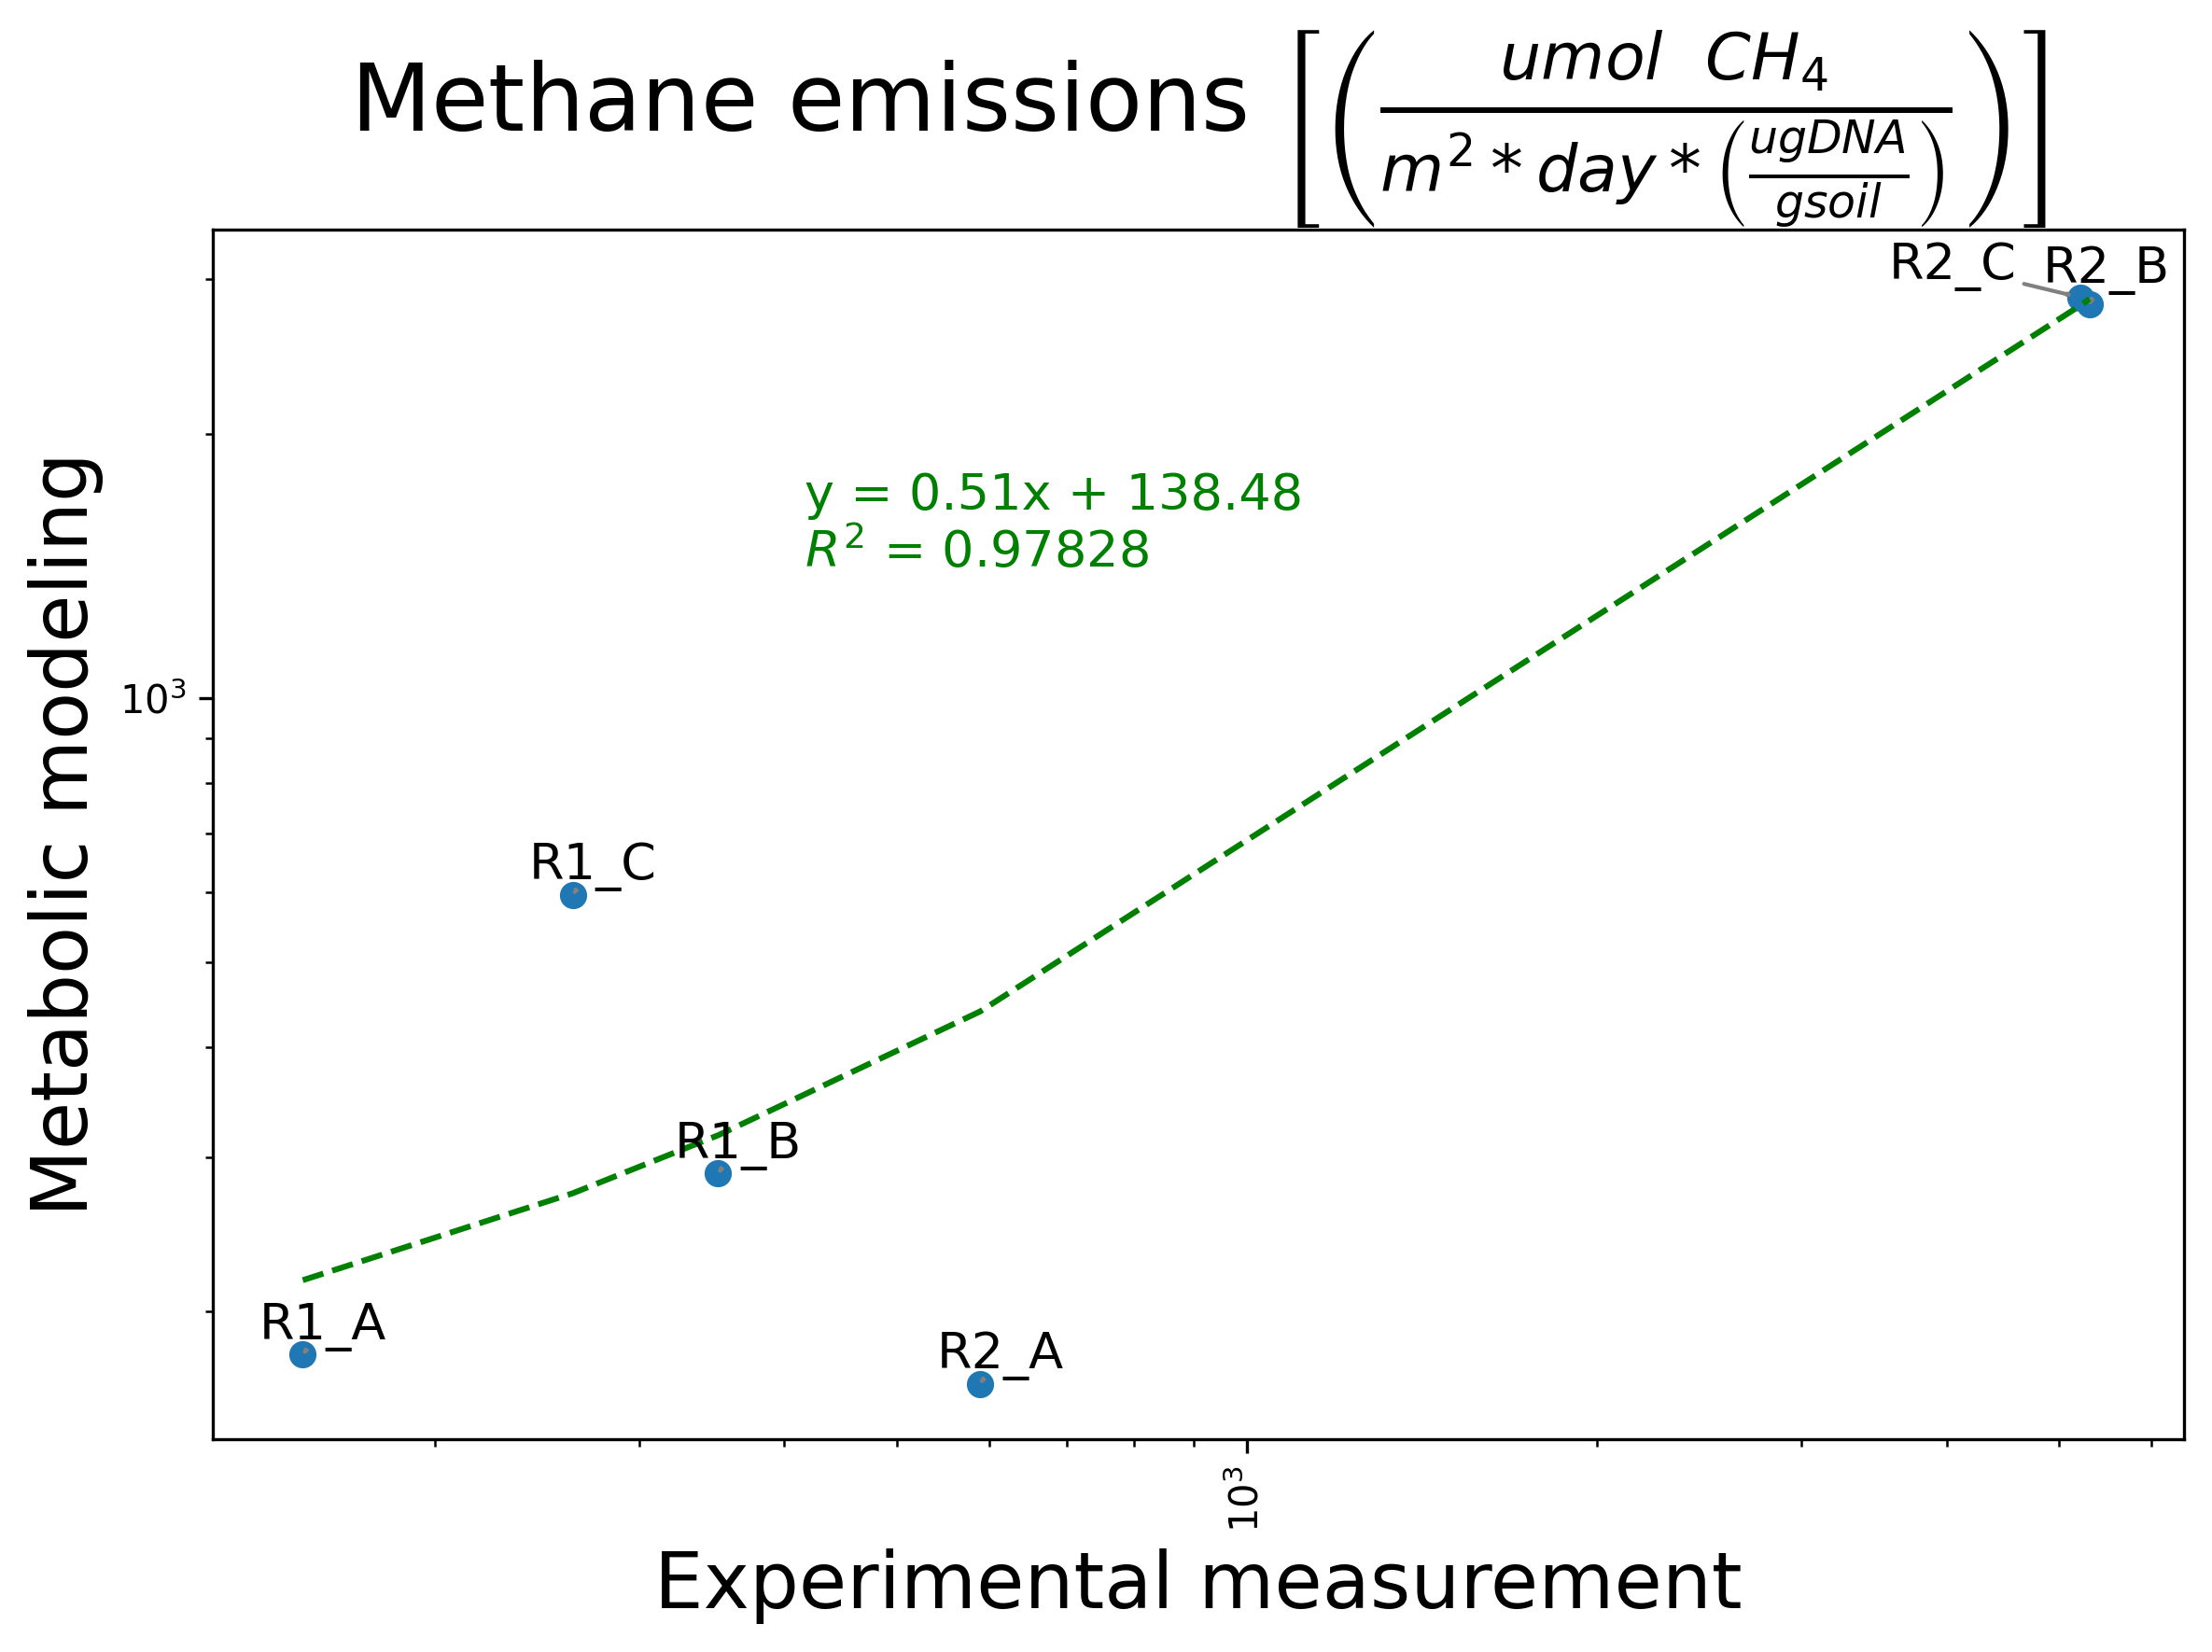

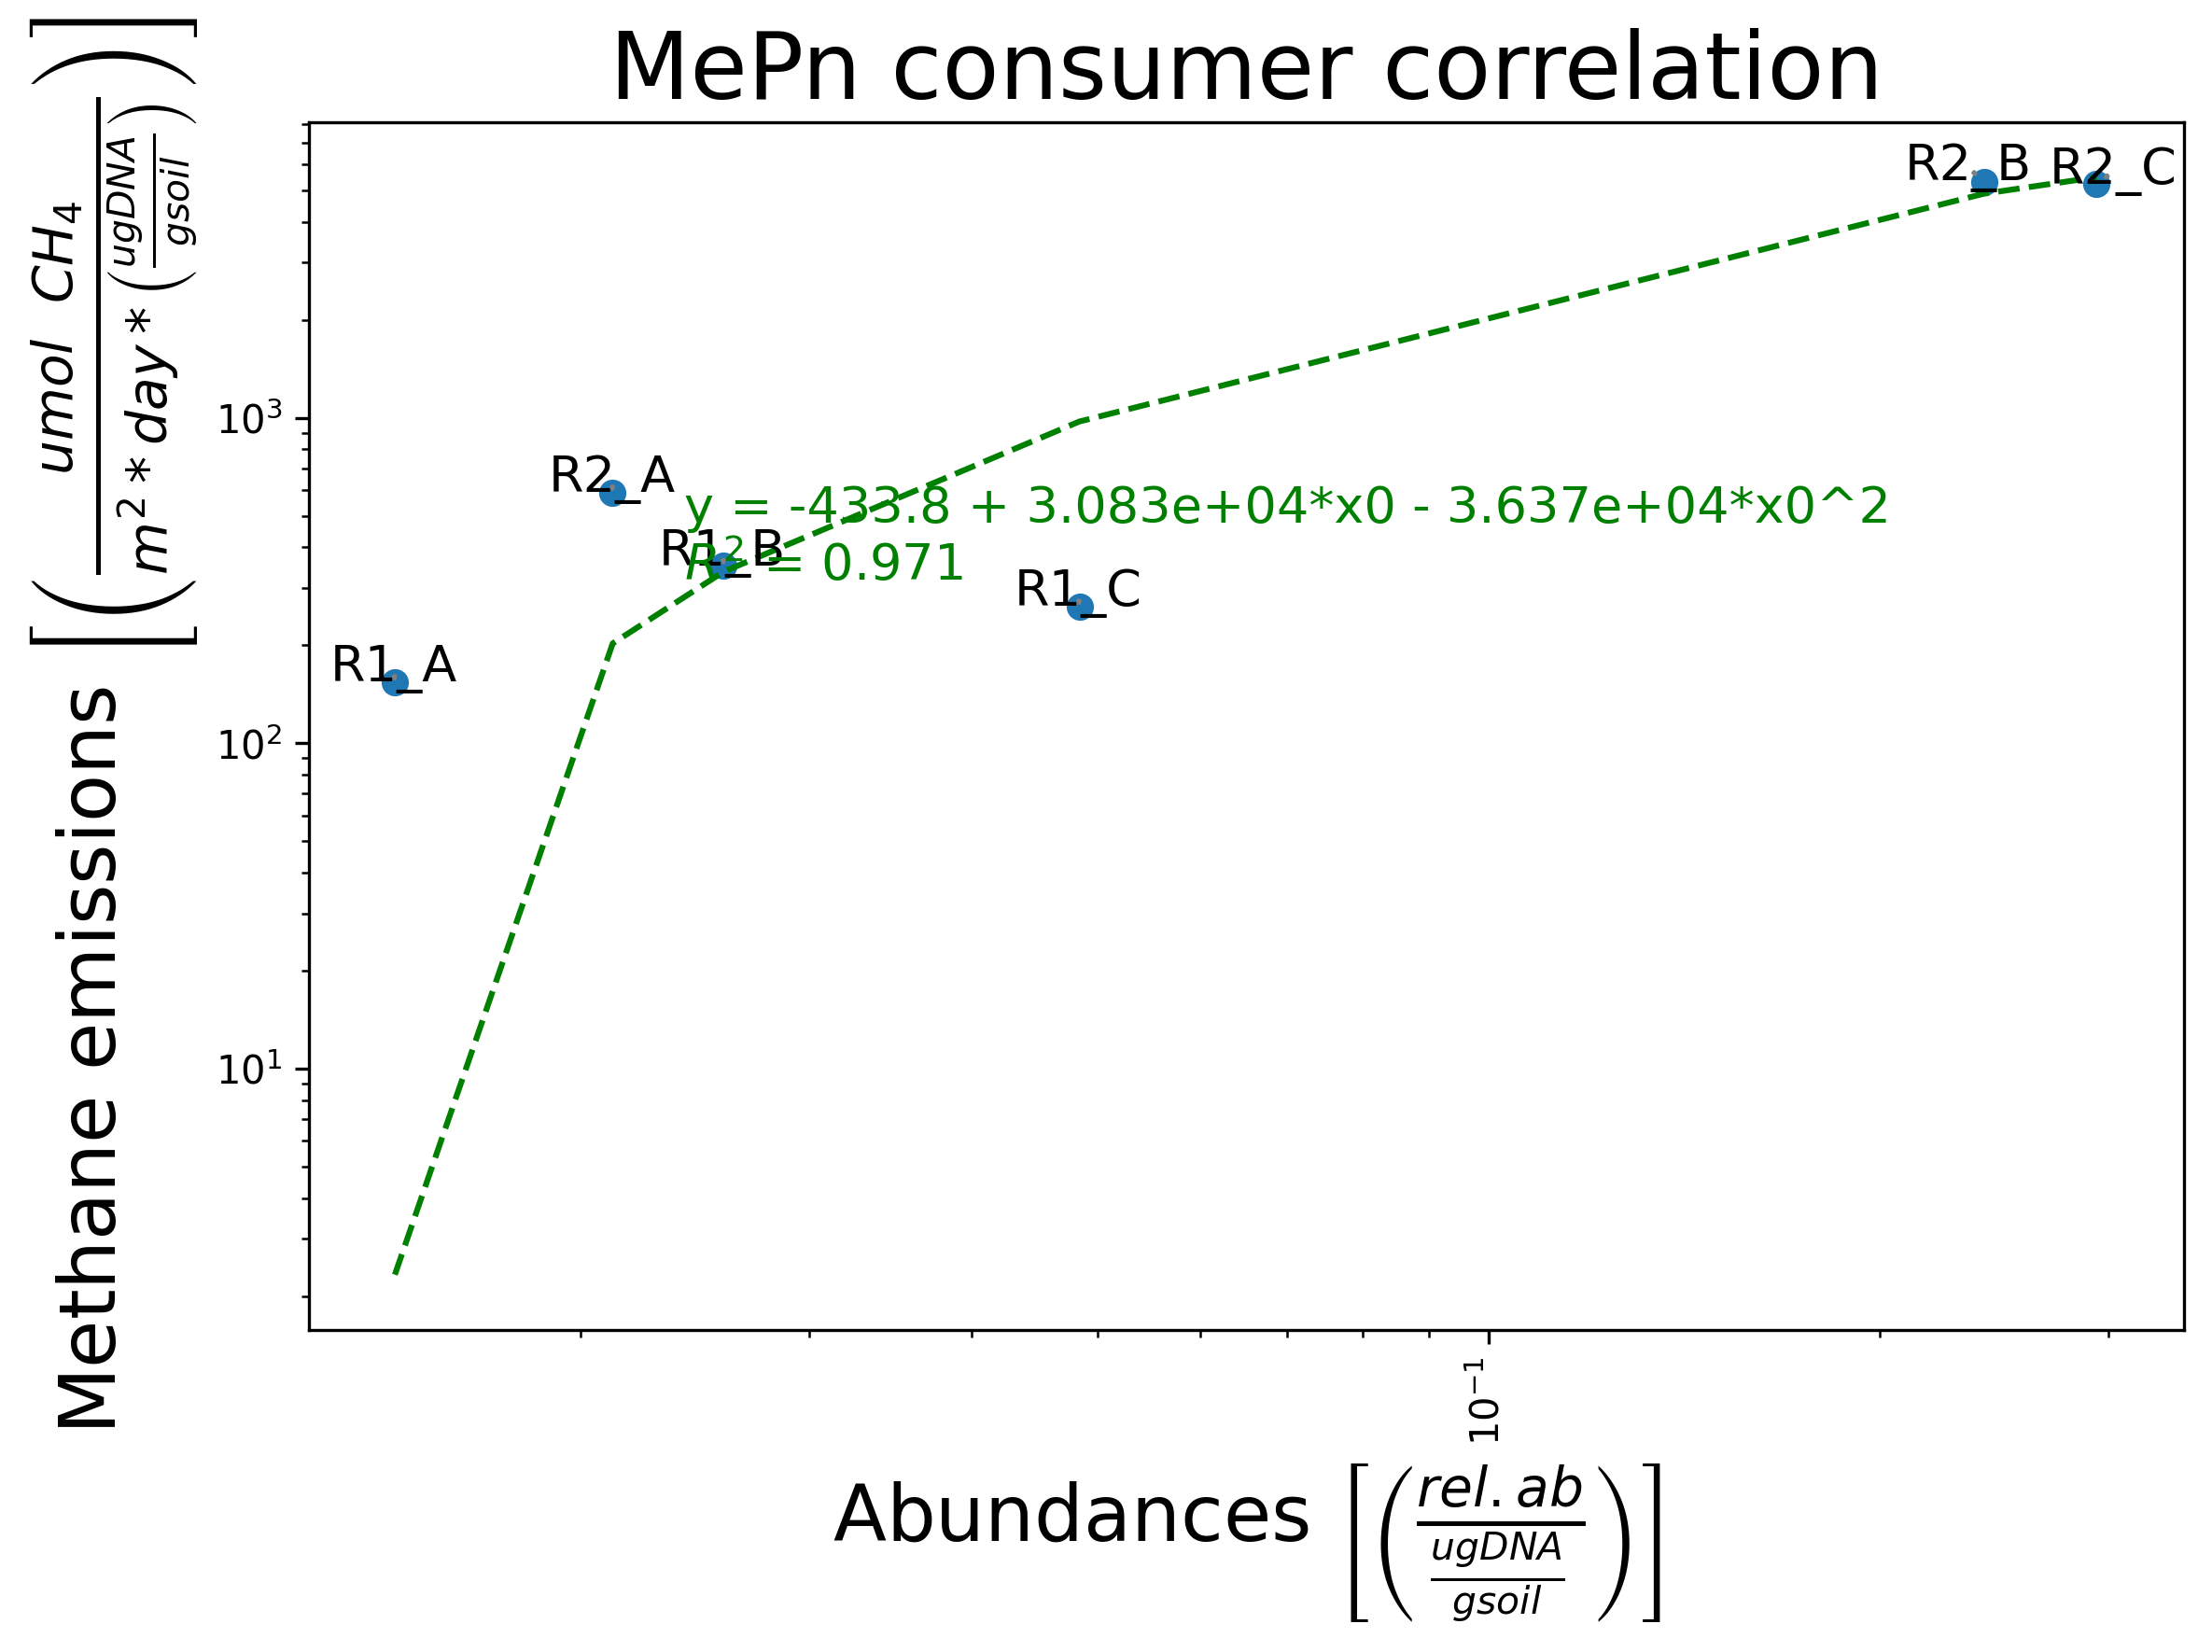

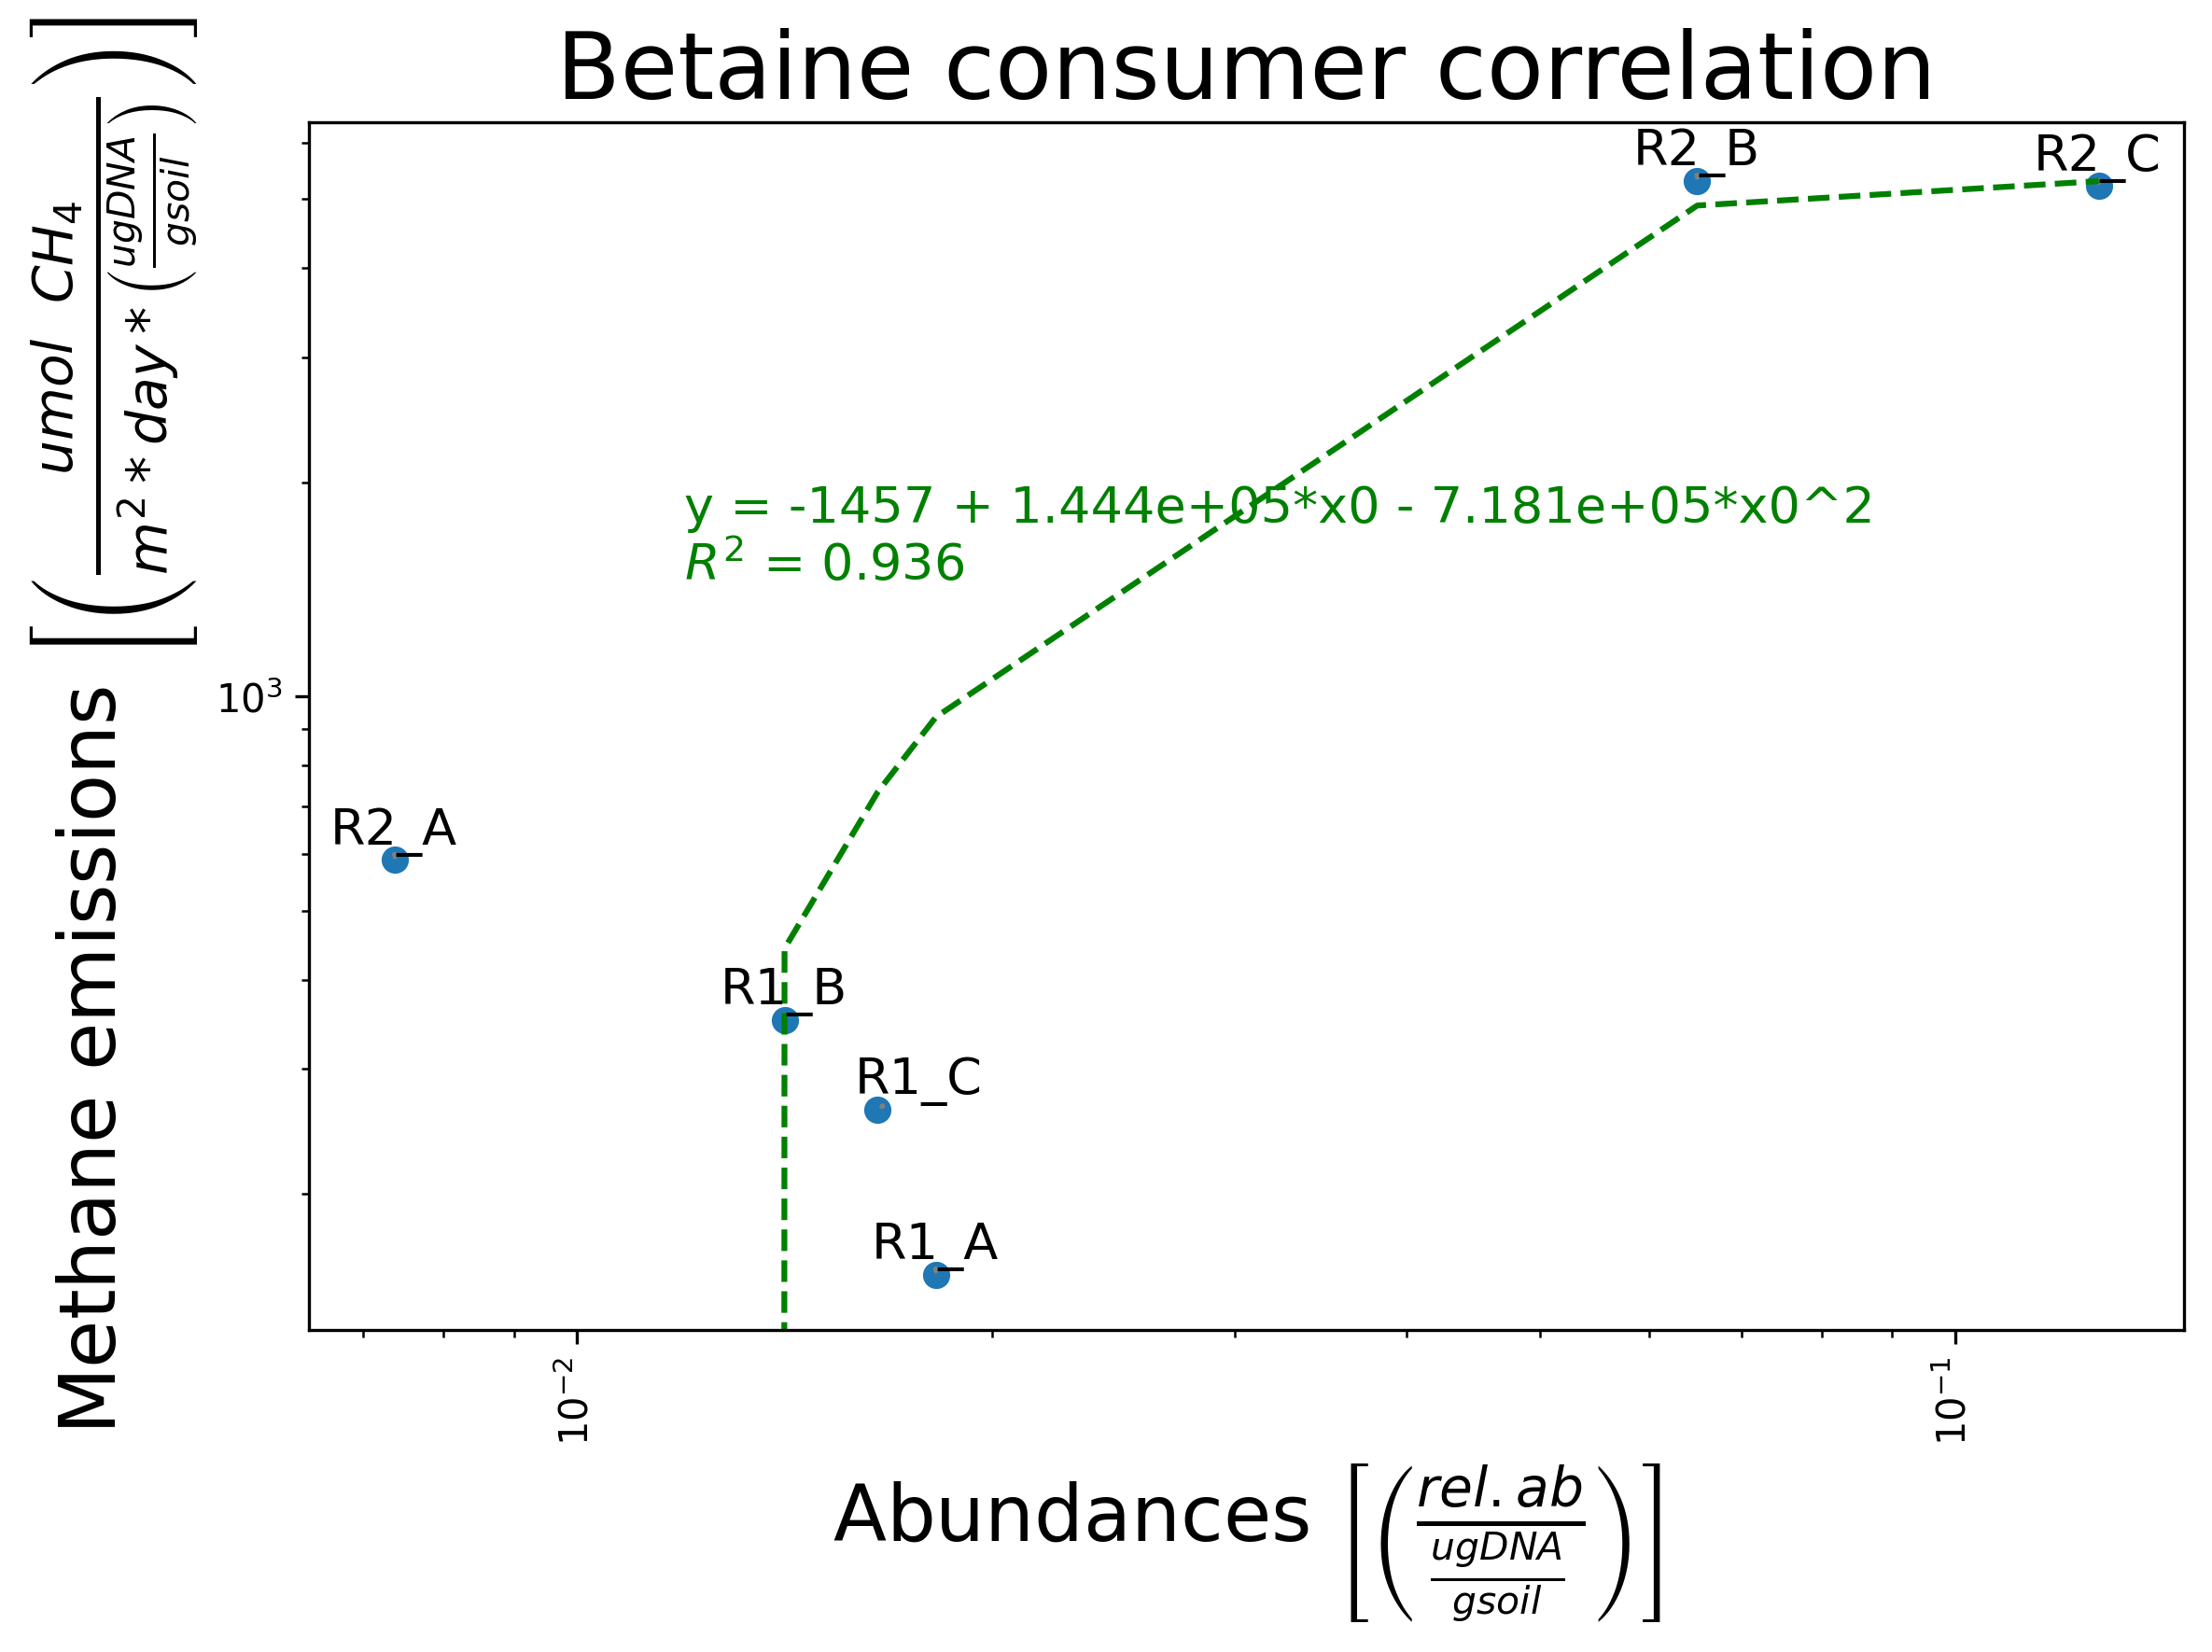

In [19]:
# correlate the methane emissions with fluxes in the experimental units
import matplotlib.pyplot as plt
# from seaborn import color_palette
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
from sklearn.metrics import r2_score
from adjustText import adjust_text
import json
from pandas import DataFrame

fluxes = json.load(open('saltern_fluxes.json'))
log = False
linear = True
# display(fluxes)


# display(DataFrame(methane_sols).T.sum())
fluxes_in_emissions = fluxes_to_emissions(DataFrame(fluxes["0.07"]["methane"]).T.sum()).to_dict()
print("fluxes_in_emissions")
display(fluxes_in_emissions)
# total_df = read_csv("../Cliff/data/Cliff_Sample_Metadata_BGC_NMR.csv").set_index("Sample")
# emissions = total_df["CH4_umol_m2_d"].loc[unrestored_cols].to_list()

combined = {ID: {"fluxes": emissions, "methane": methane_dic[ID]} for ID, emissions in fluxes_in_emissions.items()}
combined_df = DataFrame(combined).T
methane_ary = np.array(list(combined_df["methane"].values))
emission_fluxes = np.array(list(combined_df["fluxes"].values))

# plot the figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
xs = np.array(methane_ary).reshape(-1, 1)
ys = np.array(emission_fluxes)
if log:
    xs = np.log(xs)
    ys = np.log(ys)
    title = r"Methane emissions $\left[LOG\left(\frac{umol~~CH_4}{m^2*day*\left(\frac{ug DNA}{g soil}\right)}\right)\right]$"
else:
    ax.set_xscale('log'); ax.set_yscale('log')

    # Major ticks = decades
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
    ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))

    # 9 log-spaced minor ticks per decade
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))

    # Label only 10^n
    fmt = LogFormatterMathtext(base=10, labelOnlyBase=True)
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    plt.setp(ax.get_xticklabels(), rotation=90)
    title = r"Methane emissions $\left[\left(\frac{umol~~CH_4}{m^2*day*\left(\frac{ug DNA}{g soil}\right)}\right)\right]$"

print(xs, ys)

mdl = LinearRegression()
mdl.fit(xs, ys)
ax.scatter(xs, ys)
ax.grid(True, which='both', axis='both', linestyle='--', color='gray', alpha=0.3)
offset = .05
label_size = 13
texts = []
for xi, yi, label in zip(xs, ys, list(combined_df.index)):
    texts.append(plt.text(xi, yi + offset, label, fontsize=label_size, ha='center', va='bottom'))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# add the regression
y_pred = mdl.predict(xs)
trendline_color = "green"
sorted_idx = np.argsort(methane_ary)
sorted_xs = xs[sorted_idx]
sorted_ys = y_pred[sorted_idx]
ax.plot(sorted_xs, sorted_ys, color=trendline_color, linestyle='--', label='Trendline')

## create the equation for the plot
eq = f"y = {mdl.coef_[0]:.2f}x + {mdl.intercept_:.2f}"
r2_text = f"$R^2$ = {r2_score(ys, y_pred):.5f}"

# Add labels and title
ax.text(0.3, 0.8, eq + '\n' + r2_text, transform=plt.gca().transAxes, fontsize=label_size, color=trendline_color, verticalalignment='top')
axes_size = 20
plt.xlabel('Experimental measurement', fontsize=axes_size)
plt.ylabel('Metabolic modeling', fontsize=axes_size)
plt.title(title, fontsize=axes_size+4)
plt.tight_layout()
fig.savefig("experiment_modeling.png")
fig.show()



######################################################################################################
# compute the correlation between the normalized abundances and experimental methane fluxes
display(averaged_unrestored_normalized_abundances) #, unrestored_normalized_methane_df)
for samples in ["MePn", "Betaine"]:
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    if samples == "MePn":
        sample_totals = averaged_unrestored_normalized_abundances.loc[list(mepe_striped)].sum()
        title = 'MePn consumer correlation'
        export_name = "MePn_consumers_new.png"
    else:
        sample_totals = averaged_unrestored_normalized_abundances.loc[list(betaine_striped)].sum()
        title = 'Betaine consumer correlation'
        export_name = "Betaine_consumers_new.png"
    
    all_xs = np.array(sample_totals.to_list())# unrestored_normalized_abundances.to_numpy().flatten()
    xs = all_xs.reshape(-1, 1)
    all_ys = averaged_unrestored_normalized_methane.to_list() #*311)
    ys = np.array(all_ys)
    if log:
        xs = np.log(xs)
        ys = np.log(ys)
        plt.xlabel(r'Abundances $\left[LOG\left(\frac{rel.ab}{\frac{ug DNA}{g soil}}\right)\right]$', fontsize=axes_size)
        plt.ylabel(r"Methane emissions $\left[LOG\left(\frac{umol~~CH_4}{m^2*day*\left(\frac{ug DNA}{g soil}\right)}\right)\right]$", fontsize=axes_size)
    else:
        ax.set_xscale('log'); ax.set_yscale('log')

        # Major ticks = decades
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
        ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))

        # 9 log-spaced minor ticks per decade
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))

        # Label only 10^n
        fmt = LogFormatterMathtext(base=10, labelOnlyBase=True)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.xlabel(r'Abundances $\left[\left(\frac{rel.ab}{\frac{ug DNA}{g soil}}\right)\right]$', fontsize=axes_size)
        plt.ylabel(r"Methane emissions $\left[\left(\frac{umol~~CH_4}{m^2*day*\left(\frac{ug DNA}{g soil}\right)}\right)\right]$", fontsize=axes_size)

    if linear:
        model = LinearRegression()
        model.fit(xs, ys)
        y_pred = model.predict(xs)
        coef = model.coef_[0]
        intercept = model.intercept_
    else:
        # model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
        # model.fit(xs, ys)

        poly = PolynomialFeatures(degree=2, include_bias=False)
        lin  = LinearRegression()
        model = Pipeline([("poly", poly), ("lin", lin)])
        model.fit(xs, ys)
        y_pred = model.predict(xs)

        # 1) Get polynomial term names
        # If you have original column names, pass them to get_feature_names_out:
        # e.g., poly.get_feature_names_out(["x1","x2"])
        term_names = model.named_steps["poly"].get_feature_names_out()  # uses x0,x1,... by default

        # 2) Get coefficients and intercept
        coef = model.named_steps["lin"].coef_
        intercept = model.named_steps["lin"].intercept_

    display(sample_totals)
    ax.scatter(xs, ys)
    # for xi, yi, label in zip(np.log(xs), np.log(ys), list(sample_totals.index)):
    #     ax.text(xi, yi, label, fontsize=9, ha='right', va='top')  # adjust ha/va for positioning
    texts = []
    for xi, yi, label in zip(xs, ys, list(sample_totals.index)):
        texts.append(plt.text(xi, yi + offset, label, fontsize=label_size, ha='center', va='bottom'))
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

        
    # add the regression
    sorted_idx = np.argsort(all_xs)
    sorted_xs = all_xs[sorted_idx]
    sorted_ys = y_pred[sorted_idx]
    # if log:
    #     sorted_xs = np.log(sorted_xs)
    #     sorted_ys = np.log(sorted_ys)
    ax.plot(sorted_xs, sorted_ys, color=trendline_color, linestyle='--', label='Trendline')
    ax.grid(True, which='both', axis='both', linestyle='--', color='gray', alpha=0.3)
    
    ## create the equation for the plot
    if linear:
        eq = f"y = {coef:.2f}x + {intercept:.2f}"
    else:
        precision = 4
        parts = [f"{intercept:.{precision}g}"]
        for c, t in zip(coef, term_names):
            sign = " + " if c >= 0 else " - "
            parts.append(f"{sign}{abs(c):.{precision}g}*{t}")
        eq = "y = " + "".join(parts)
        # print(model.named_steps['polynomialfeatures'].coef_)
        # eq = f"y = {model.named_steps['polynomialfeatures'].coef_}x^3 + {model.named_steps['linearregression'].intercept_:.2f}"
    r2_text = f"$R^2$ = {r2_score(all_ys, y_pred):.3f}"
    
    # Add labels and title
    ax.text(0.2, 0.7, eq + '\n' + r2_text, transform=plt.gca().transAxes, fontsize=label_size, color=trendline_color, verticalalignment='top')

    plt.title(title, fontsize=axes_size+4)
    plt.tight_layout()
    fig.savefig(export_name)
    fig.show()